In [1]:
import torch
import torchvision
from torch import nn
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm

In [2]:
model = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    freq_base = 2,
    depth = 3,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 256,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 32,         # number of dimensions per cross attention head
    latent_dim_head = 32,        # number of dimensions per latent self attention head
    num_classes = 91,          # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 8      # number of self attention blocks per cross attention
)

# img = torch.randn(1, 28, 28, 1) # 1 imagenet image, pixelized

# model(img).shape # (1, 1000)
model_name = 'baseline'

In [3]:
# imagenet_data = torchvision.datasets.ImageNet('/home/gabriel/Documents/datasets/')
# data_loader = torch.utils.data.DataLoader(imagenet_data,
#                                           batch_size=32,
#                                           shuffle=True,
#                                           num_workers=20)
# train_loader, val_loader, test_loader

In [4]:
# train_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))
# val_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))
# test_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))

# bs = 16
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=bs,
#                                            shuffle=True,
#                                            num_workers=20)
# val_loader = torch.utils.data.DataLoader(val_data,
#                                            batch_size=bs,
#                                            shuffle=False,
#                                            num_workers=20)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                            batch_size=bs,
#                                            shuffle=False,
#                                            num_workers=20)

In [5]:
# torch.manual_seed(0)

# batch_size = 16

# mnist_train = torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ]))
# train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=10)
# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size, shuffle=True, num_workers=10)

In [19]:
class CocoMultilabelDataset(torch.utils.data.Dataset):
    def __init__(self, coco_dataset):
        self.coco_dataset = coco_dataset
        
    def __getitem__(self, index):
        target = torch.zeros((91,))
        for det in self.coco_dataset[index][1]:
            if det['category_id'] > 90:
                print(det)
            target[det['category_id']] = 1
        return (self.coco_dataset[index][0], target)
    
    def __len__(self):
        return len(self.coco_dataset)

torch.manual_seed(0)
batch_size = 16
coco_train = torchvision.datasets.CocoDetection(root = '/home/gabriel/Documents/datasets/COCO/train2017',
                                                annFile = '/home/gabriel/Documents/datasets/COCO/annotations/instances_train2017.json',
                                                transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(
                                                        (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                ]))
coco_train = CocoMultilabelDataset(coco_train)
split = int(0.9 * len(coco_train))
train_set, val_set = torch.utils.data.random_split(coco_train, [split, len(coco_train) - split])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10)
test_set = torchvision.datasets.CocoDetection(root = '/home/gabriel/Documents/datasets/COCO/val2017',
                                              annFile = '/home/gabriel/Documents/datasets/COCO/annotations/instances_val2017.json',
                                              transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((224, 224)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                              ]))
test_set = CocoMultilabelDataset(test_set)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=10)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [7]:
len(coco_train)

118287

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


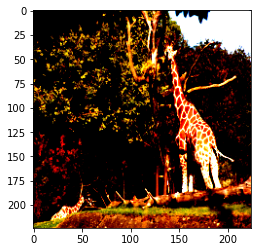

In [8]:
im = torch.transpose(torch.transpose(coco_train[1][0], 0, 1), 1, 2)
plt.imshow(im.cpu().numpy())
plt.show()

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

max_epochs = 2  # 50

# checkpoint = torch.load(f'checkpoints/{model_name}/best_checkpoint.pt')
# model.load_state_dict(checkpoint['state_dict'])
model.to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = 100000.0

loss_thresh = 0
writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    loss_sum = 0
    loss_count = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
#         from matplotlib import pyplot as plt
#         plt.imshow(X_batch[0].cpu().numpy())
#         plt.show()
#         print(X_batch.shape, y_batch.shape)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        writer.add_scalars("losses", {"train_loss": loss.data}, epoch * len(train_loader) + batch_idx)
        
    model.eval()
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.data
    
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    
    writer.add_scalars("losses", {"val_loss": val_loss}, (epoch + 1) * len(train_loader) - 1)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint.pt')
        val_loss_min = val_loss

cuda:0


Epoch 1/2:   0%|          | 0/6654 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.007069 	Validation Loss: 0.006682
Validation loss decreased (100000.000000 --> 0.006682).  Saving model ...


Epoch 2/2:   0%|          | 0/6654 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.006590 	Validation Loss: 0.006404
Validation loss decreased (0.006682 --> 0.006404).  Saving model ...


In [25]:
def multilabel_acc(y_pred, y_true):
    correct = 0
    total = 0
    for i in tqdm(range(len(y_true)), desc=f"Computing accuracy"):
        pred = y_pred[i]
        true = y_true[i]
        for j in range(len(true)):
            total += 1
            if true[j] == 1:
                if round(float(pred[j])) == 1:
                    correct += 1
            elif round(float(pred[j])) == 0:
                correct += 1
                
    return correct / total


# def multilabel_prec(y_pred, y_true):
#     correct = 0
#     total = 0
#     for i in tqdm(range(len(y_true)), desc=f"Computing precision"):
#         pred = y_pred[i]
#         true = y_true[i]
#         for j in range(len(true)):
#             total += 1
#             if true[j] == 1:
#                 if round(float(pred[j])) == 1:
#                     correct += 1
#             elif round(float(pred[j])) == 0:
#                 correct += 1
                
#     return correct / total


# def multilabel_recall(y_pred, y_true):
#     correct = 0
#     total = 0
#     for i in tqdm(range(len(y_true)), desc=f"Computing recall"):
#         pred = y_pred[i]
#         true = y_true[i]
#         for j in range(len(true)):
#             total += 1
#             if true[j] == 1:
#                 if round(float(pred[j])) == 1:
#                     correct += 1
#             elif round(float(pred[j])) == 0:
#                 correct += 1
                
#     return correct / total

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)
checkpoint = torch.load(f'checkpoints/{model_name}/best_checkpoint.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
# m = nn.Softmax(dim=1)
m = nn.Sigmoid()
y_pred_extended = []
y_true_extended = []
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(test_loader, desc=f"Inference")):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
        y_pred = model(X_batch).cpu()
        #         print(y_pred)
        y_pred = m(y_pred)
        #         print(y_pred)
#         y_pred = np.argmax(y_pred, axis=1)
        #         print(y_pred, y_batch.cpu())
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_batch.cpu())
        
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         #print("Normalized confusion matrix")
#     #else:
#         #print('Confusion matrix, without normalization')

#     #print(cm)
    
#     plt.figure(figsize=(25,25))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
    
# accuracy = accuracy_score(y_pred_extended, y_true_extended)
# cr = classification_report(y_true_extended, y_pred_extended)
# print(accuracy)
# print(cr)
# cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended)
# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in list(range(10))], title = ('Confusion Matrix'))
# plt.show()
accuracy = multilabel_acc(y_pred_extended, y_true_extended)
# precision = multilabel_prec(y_pred_extended, y_true_extended)
# recall = multilabel_recall(y_pred_extended, y_true_extended)
print(accuracy)  # , precision, recall)

Inference:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# model = Perceiver(
#     input_channels = 3,          # number of channels for each token of the input
#     input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
#     num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
#     max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
#     freq_base = 2,
#     depth = 2,                   # depth of net. The shape of the final attention mechanism will be:
#                                  #   depth * (cross attention -> self_per_cross_attn * self attention)
#     num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
#     latent_dim = 256,            # latent dimension
#     cross_heads = 1,             # number of heads for cross attention. paper said 1
#     latent_heads = 2,            # number of heads for latent self attention, 8
#     cross_dim_head = 32,         # number of dimensions per cross attention head
#     latent_dim_head = 32,        # number of dimensions per latent self attention head
#     num_classes = 1000,          # output number of classes
#     attn_dropout = 0.,
#     ff_dropout = 0.,
#     weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
#     fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
#     self_per_cross_attn = 2      # number of self attention blocks per cross attention
# )

# print(len(model.layers))

In [ ]:
# model.layers.append(model.layers[1])
# print(len(model.layers))